<a href="https://colab.research.google.com/github/VVdovichev/ML_in_Business/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
!pip install catboost
!pip install scikit-uplift


import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.models import (SoloModel, ClassTransformation, TwoModels)
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

__1.__ скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [157]:
df = pd.read_csv('data.csv')

In [158]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


__2.__ там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [159]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df['treatment'] = df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [160]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


__3.__  сделать разбиение набора данных не тренировочную и тестовую выборки

In [161]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),  df['target'], test_size=0.3, random_state=42, stratify=df['target'])

__5.__ провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

##SoloModel

In [162]:
cat_features = ['zip_code', 'channel']
params = {'cat_features': cat_features}
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], estimator_fit_params=params)

In [163]:
uplift_sm = sm.predict(X_test.drop(columns='treatment'))

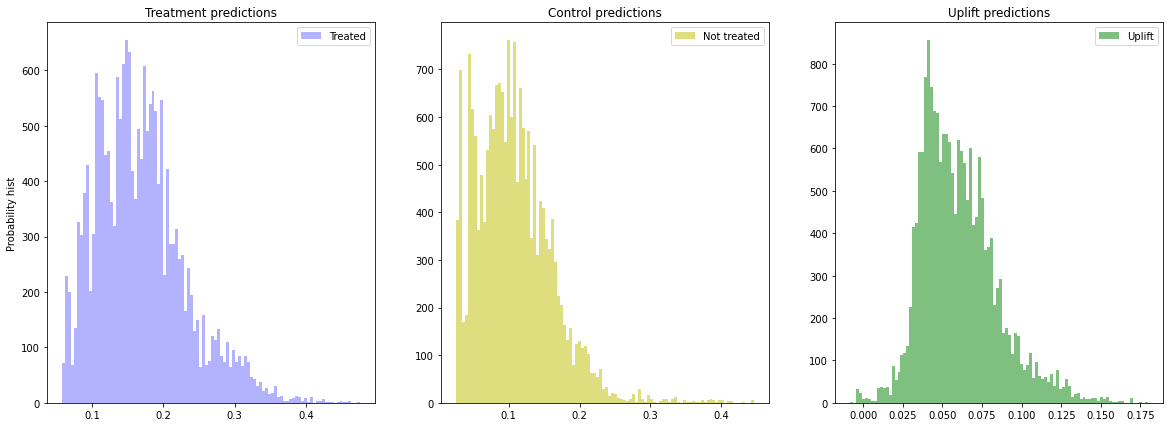

In [164]:
plot_uplift_preds(sm.trmnt_preds_, sm.ctrl_preds_);

In [165]:
df_metrics = pd.DataFrame({
    '10%': uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    '20%': uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], k=0.2, strategy='by_group')
}, index=['SoloModel'])

##ClassTransformation

In [166]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train.drop(columns='treatment'), y_train, X_train['treatment'], estimator_fit_params=params)

In [167]:
uplift_ct = ct.predict(X_test.drop(columns='treatment'))

In [168]:
df_metrics.loc['ClassTransformation', :] = [
    uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], k=0.2, strategy='by_group')
]

##TwoModels

In [169]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train.drop(columns='treatment'), y_train, X_train['treatment'],
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test.drop(columns='treatment'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49a7d2d550>,
      dtype=object)

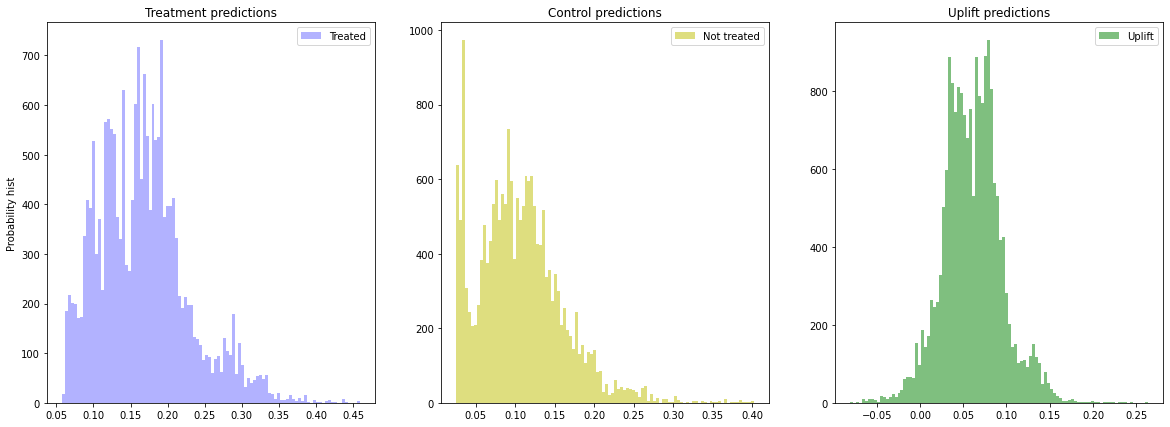

In [170]:
plot_uplift_preds(tm.trmnt_preds_, tm.ctrl_preds_)

In [171]:
df_metrics.loc['TwoModels', :] = [
    uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], k=0.1, strategy='by_group'),
    uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], k=0.2, strategy='by_group')
]

__6.__ в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [172]:
df_metrics

,10%,20%
SoloModel,0.101346,0.079180
ClassTransformation,0.083072,0.079170
TwoModels,0.080466,0.077357
